In [411]:
import pandas as pd
import numpy as np
import classification_tools

import importlib
importlib.reload(classification_tools)

pd.set_option("display.max_columns",500)

import warnings
# suppress matplotlib warning in plot_confusion_matrix()
warnings.filterwarnings('ignore', message='FixedFormatter should only be used together with FixedLocator')



## Load Data


In [412]:
df_simd = pd.read_csv("data/simd_2020_ward.csv", index_col=0)
df_stopsearch = pd.read_csv("data/stop_search_clean.csv", index_col=0)
df_stopsearch = df_stopsearch.rename(columns={"Multi Member Ward":"ward_code"})

df_init = df_stopsearch.merge(right=df_simd, how="left", on="ward_code", validate="many_to_one")
df_init


,ward_code,Year,Month,Day of the Week,Time of the Day,Search Result,Nominal Age,Desc Drugs Found_Class B,Desc Drugs Found_Class C,Desc Drugs Found_Class A,Desc Off Weap Found_Other,Desc Other Items Found_Other,Desc Off Weap Found_Bladed Instrument,Desc Other Items Found_Firearms,Desc Off Weap Found_Pointed Article,Desc Other Items Found_Stolen Property,Desc Off Weap Found_Blunt Instrument,Desc Tobacco Found_Tobacco,Desc Other Items Found_Disposal Of Cash,Desc Alcohol Found_Beer,Desc Tobacco Found_Cigarette Papers,Desc Drugs Found_Nps,Desc Alcohol Found_Wine,Desc Alcohol Found_Spirits,Desc Other Items Found_Crossbows,Desc Other Items Found_Controlled Container,Desc Alcohol Found_Cider,Desc Other Items Found_Fireworks,Nominal Ethnicity_Any Mixed Ethnic group,"Nominal Ethnicity_Arab, Arab Scottish, Arab British","Nominal Ethnicity_Bangladeshi, Bangladeshi Scottish, Bangladeshi British","Nominal Ethnicity_Black, Black Scottish, Black British","Nominal Ethnicity_Caribbean, Caribbean Scottish, Caribbean British","Nominal Ethnicity_Chinese, Chinese Scottish, Chinese British","Nominal Ethnicity_Indian, Indian Scottish, Indian British",Nominal Ethnicity_Not Provided / Unknown,Nominal Ethnicity_Other African,Nominal Ethnicity_Other Asian,Nominal Ethnicity_Other Caribbean or Black,Nominal Ethnicity_Other Ethnic Group,"Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British","Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British",Nominal Ethnicity_White British,Nominal Ethnicity_White English,Nominal Ethnicity_White Gypsy/Traveller,Nominal Ethnicity_White Irish,Nominal Ethnicity_White Northen Ireland,Nominal Ethnicity_White Other,Nominal Ethnicity_White Polish,Nominal Ethnicity_White Scottish,Nominal Ethnicity_White Welsh,Search Statute_CONTROLLED CONTAINERS - Sec 21 Criminal Law (Consolidation) (Scotland) Act 1995,Search Statute_CONTROLLLED ARTICLE OR SUBSTANCE - Sec 21 Criminal Law (Consolidation) (Scotland) Act 1995,Search Statute_Edinburgh Airport Byelaw 9(2) (Search in interest of public safety),"Search Statute_Sec 109(1) Copyright, Designs and Patents Act 1988 (Piracy and trademark offences etc)",Search Statute_Sec 11 of the Protection of Badgers Act 1992 (Wildlife Crime),Search Statute_Sec 11A of the Fireworks Act 2003,Search Statute_Sec 19 of the Wildlife and Countryside Act 1981,Search Statute_Sec 20 & 32 Police and Fire Reform (Scotland) Act 2012 (Other),Search Statute_Sec 20 & 32 Police and Fire Reform (Scotland) Act 2012 (Protection of Life),Search Statute_Sec 23(2) of the Misuse of Drugs Act 1971 (Drugs),Search Statute_Sec 23(3) Misuse Of Drugs Act 1971,Search Statute_Sec 23A of the Misuse of Drugs Act 1971 (Drugs),"Search Statute_Sec 24(1) Forgery and Counterfeiting Act, 1981 (Search for counterfeit money)",Search Statute_Sec 27 Deer (Scotland) Act 1996,Search Statute_Sec 289 Proceeds of Crime Act 2002 (Cash),Search Statute_Sec 4 of the Crossbows Act 1987,Search Statute_Sec 46(1) Firearms Act 1968,Search Statute_Sec 47(1) Firearms Act 1968 (Firearms),Search Statute_Sec 48(1) of the Criminal Law (Consolidation) (Scotland) Act 1995 (Offensive Weapon),Search Statute_Sec 49B of the Criminal Law (Consolidation) (Scotland) Act 1995 (Bladed Weapon/Offensive Weapon Schools),Search Statute_Sec 50 of the Criminal Law (Consolidation) (Scotland) Act 1995 (Bladed Weapon),Search Statute_Sec 53(1) of The Salmon and Freshwater Fisheries (Consolidation)(Scotland) Act 2003,Search Statute_Sec 60 Criminal Justice and Public Order Act 1994,Search Statute_Sec 60(1) Civic Government (Scotland) Act 1982 (Stolen Property),Search Statute_Sec 66 Criminal Justice (Scotland) Act 2016 (Removal of person),Search Statute_Sec 7 of the Wild Mammals (Scotland) Act 2002 (Wildlife Crime),Search Statute_Warrant - Other,Nominal Gender_Male,Nominal Physical Search Type_STRIP_IS,Nominal Physical Search Type_STRIP_OS,Command Desc_3,Command Desc_East,Command Desc_North,Command Desc_West,Division Desc_13,Division Desc_Argyll and West Dunbartons

In [413]:
label = "Search Result"
s_labels = df_init[label]
df_init = df_init.drop(label, axis=1)
df_init = df_init.drop("ward_code", axis=1)

## Split Data

In [414]:
from sklearn.model_selection import train_test_split

X_train_init, X_val_init, y_train, y_val = train_test_split(df_init.copy(), s_labels.copy(), random_state=42, test_size=0.5)
X_test_init, X_val_init, y_test, y_val = train_test_split(X_val_init, y_val, random_state=42, test_size=0.5)

# Initial Model

Intuitively we might expect the stop and search data on its own to have some predictive power in the outcome of a stop and search. We'll first build this model and then try and improve upon it with the deprivation data.

We have a lot of features even in just the stop and search data - many of them one hot encodings of categorical variables. We will try and cut them down to what we think are the most useful initially.

- The date/time columns are difficult to work with, so we will drop those initially.
- Descriptions of items found are not predicting features, they would be targets and these can be our stretch goal for the project.
- The search statute and search reason could be useful but have a feeling they could be well correlated, can we explore this?
- Age, gender, ethnicity are definitely going to be important.
- Command Code, Area Command Code and Council code could be useful to link areas that are close together or operate under the same police command.

Initially, we'll start with just Age, Gender and Ethinicity


In [415]:
cols = X_train_init.columns[X_train_init.columns.str.contains("Nominal Ethnicity.*", regex=True)].to_list()
cols += ["Nominal Age", "Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

model="Age, Ethnicity, Gender"
#don't apply regularisation: our features are not standaridezed and we want to avoid this to aid interpretation
models[model] = LogisticRegression(
    penalty="none",
    max_iter=300
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

Training score: 0.642
Validation Score:0.646


### Accuracy

In [416]:
positive = y_train[y_train==1].count()
negative = y_train[y_train==0].count()

print(f"Proportion of positive outcomes = {positive/(positive+negative)}")

Proportion of positive outcomes = 0.3578378668960327


Given that our data is split approximately 1/3 and 2/3 positive and negative outcomes, a 64% accuracy could mean our model is successful just always predicting negative.

We can check other metrics to explore how effective our model actually is:
- True positive rate and false negative rates
- AUC ROC score

### Confusion Matrix

True Negatives: 23,852
False Positives: 39
False Negatives: 13,270
True Positives: 43

True positive rate: 0.003230
False positive rate: 0.001632
Confusion matrix:
 [[23852    39]
 [13270    43]]


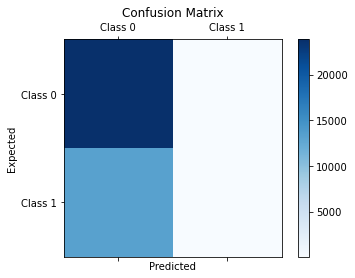

In [417]:
from sklearn.metrics import confusion_matrix

y_train_pred = classification_tools.predict_with_threshold(models[model], X_train, threshold=0.5)
conf_mat = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = conf_mat.ravel()

print("True Negatives: {:,}\nFalse Positives: {:,}\nFalse Negatives: {:,}\nTrue Positives: {:,}\n".format(tn,fp,fn,tp))

print("True positive rate: {:3f}".format(tp/(tp+fn)))
print("False positive rate: {:3f}".format(fp/(tn+fp)))

classification_tools.plot_confusion_matrix(conf_mat)


False positive rate is very low, this is good!

True positive rate is very low, this is bad.

The total propotion of positive predictions is very low, our model has simply learned to always predict negative. The ROC curve should backup the poor performance of our model.

### ROC Curve

#### Train

In [418]:
fig, auc = classification_tools.calc_roc(models[model], X_train, y_train)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

AUC ROC score: 0.521


#### Validate

In [419]:
fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

AUC ROC score: 0.509


And it does. The area under the curve is barely over 50%.

Interpreting this: ethnicity, age and gender are not (or, rather, are only very midly) predictive of the outcome of a stop and search in Scotland.

What do they indidiual cofficients look like?

### Coefficients

In [420]:
coefficients = classification_tools.get_feature_weights(cols, models[model])


 8.82e-01: Nominal Ethnicity_Bangladeshi, Bangladeshi Scottish, Bangladeshi British
-7.25e-01: Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British 
-6.84e-01: Nominal Ethnicity_White Northen Ireland
-5.69e-01: Nominal Ethnicity_White Gypsy/Traveller
 4.66e-01: Nominal Ethnicity_Arab, Arab Scottish, Arab British
-4.60e-01: Nominal Ethnicity_Not Provided / Unknown
-4.16e-01: Nominal Ethnicity_Other Caribbean or Black
-3.35e-01: Nominal Ethnicity_Any Mixed Ethnic group
 2.78e-01: Nominal Ethnicity_Other Asian
-2.72e-01: Nominal Ethnicity_Caribbean, Caribbean Scottish, Caribbean British
-2.51e-01: Nominal Ethnicity_Indian, Indian Scottish, Indian British
 2.50e-01: Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British
-2.37e-01: Nominal Ethnicity_White Other
-1.62e-01: Nominal Ethnicity_White Scottish
 1.47e-01: Nominal Gender_Male
-1.39e-01: Nominal Ethnicity_Black, Black Scottish, Black British
-1.39e-01: Nominal Ethnicity_Other African
 1.26e-01: Nominal Ethn

Age seems to be having very little effect, how does the model perform without it?

In [421]:
cols = X_train_init.columns[X_train_init.columns.str.contains("Nominal Ethnicity.*", regex=True)].to_list()
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

model="Ethnicity, Gender"

models[model] = LogisticRegression(
    penalty="none",
    max_iter=300
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

Training score: 0.642
Validation Score:0.646


In [422]:
fig, auc = classification_tools.calc_roc(models[model], X_train, y_train)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

AUC ROC score: 0.521


In [423]:
fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

AUC ROC score: 0.509


In [424]:
coefficients = classification_tools.get_feature_weights(cols, models[model])

-1.01e+00: Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British 
 7.60e-01: Nominal Ethnicity_Bangladeshi, Bangladeshi Scottish, Bangladeshi British
-7.38e-01: Nominal Ethnicity_White Northen Ireland
-6.40e-01: Nominal Ethnicity_White Gypsy/Traveller
-5.76e-01: Nominal Ethnicity_Not Provided / Unknown
-5.24e-01: Nominal Ethnicity_Other Caribbean or Black
-4.91e-01: Nominal Ethnicity_Caribbean, Caribbean Scottish, Caribbean British
-4.77e-01: Nominal Ethnicity_Any Mixed Ethnic group
-3.75e-01: Nominal Ethnicity_Indian, Indian Scottish, Indian British
-3.57e-01: Nominal Ethnicity_White Other
-2.88e-01: Nominal Ethnicity_White Scottish
-2.78e-01: Nominal Ethnicity_Other African
-2.76e-01: Nominal Ethnicity_White Irish
 2.61e-01: Nominal Ethnicity_Arab, Arab Scottish, Arab British
-2.57e-01: Nominal Ethnicity_Black, Black Scottish, Black British
-2.40e-01: Nominal Ethnicity_White English
-2.21e-01: Nominal Ethnicity_Chinese, Chinese Scottish, Chinese British
 1.65e-01: Nomina

AUC score is about the same, but the ROC graph is now consistently above the baseline of 0.5 and is less sensitive to threshold choice. This model should generally perform more consistently against real data.

What about Gender and Ethnicity Independently?

In [425]:
cols = X_train_init.columns[X_train_init.columns.str.contains("Nominal Ethnicity.*", regex=True)].to_list()
X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

model="Ethnicity"

models[model] = LogisticRegression(
    penalty="none"
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

print("Coefficents:")
coefficients = classification_tools.get_feature_weights(cols, models[model])

Training score: 0.642
Validation Score:0.646


AUC ROC score: 0.503
Coefficents:
-9.99e-01: Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British 
 7.73e-01: Nominal Ethnicity_Bangladeshi, Bangladeshi Scottish, Bangladeshi British
-7.48e-01: Nominal Ethnicity_White Northen Ireland
-6.67e-01: Nominal Ethnicity_White Gypsy/Traveller
-5.92e-01: Nominal Ethnicity_Not Provided / Unknown
-5.27e-01: Nominal Ethnicity_Other Caribbean or Black
-4.85e-01: Nominal Ethnicity_Caribbean, Caribbean Scottish, Caribbean British
-4.79e-01: Nominal Ethnicity_Any Mixed Ethnic group
-3.74e-01: Nominal Ethnicity_Indian, Indian Scottish, Indian British
-3.72e-01: Nominal Ethnicity_White Other
-3.08e-01: Nominal Ethnicity_White Scottish
-2.93e-01: Nominal Ethnicity_White Irish
-2.79e-01: Nominal Ethnicity_Other African
-2.60e-01: Nominal Ethnicity_Black, Black Scottish, Black British
 2.58e-01: Nominal Ethnicity_Arab, Arab Scottish, Arab British
-2.56e-01: Nominal Ethnicity_White English
-2.54e-01: Nominal Ethnicity_Chinese, Chinese Scottish,

In [426]:
cols = ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

model="Gender"

models[model] = LogisticRegression(
    penalty="none"
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))
print("Coefficents:")
print("Gender: {:.3f}".format(models[model].coef_[0][0]))

Training score: 0.642
Validation Score:0.647


AUC ROC score: 0.508
Coefficents:
Gender: 0.147


It seems these two combined give the limited predictive power this model has, so we'll use this combination as a base to try and improve upon.

# Search Reason

Intuitively search reason seems like it could be a strong predictor and indeed it is. The total number of positive predictions has now doubled and our AUC ROC score has improved by 0.05%. This still going to be barely better than a coin toss, but is progress!

Training score: 0.642
Validation Score:0.645


Train AUC ROC score: 0.554


Validate AUC ROC score: 0.554
True Negatives: 23,815
False Positives: 76
False Negatives: 13,242
True Positives: 71

True positive rate: 0.005333
False positive rate: 0.003181
Confusion matrix:
 [[23815    76]
 [13242    71]]


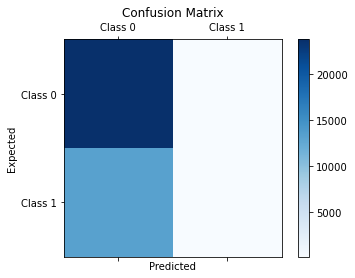

Coefficents:
-1.73e+01: Search Reason_Public Order
 5.22e+00: Search Reason_Warrant
 5.16e+00: Search Reason_Stolen Property
-5.16e+00: Search Reason_Crossbows
 4.86e+00: Search Reason_Drugs
 4.49e+00: Search Reason_Protection Of Life
 4.48e+00: Search Reason_Firearms
 4.41e+00: Search Reason_Fireworks
 4.32e+00: Search Reason_Weapons
 4.27e+00: Search Reason_Wildlife
 4.23e+00: Search Reason_Sport Event
 4.22e+00: Search Reason_Other
 3.41e+00: Search Reason_Care & Welfare
-1.01e+00: Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British 
 7.66e-01: Nominal Ethnicity_Bangladeshi, Bangladeshi Scottish, Bangladeshi British
-7.19e-01: Nominal Ethnicity_White Northen Ireland
-5.94e-01: Nominal Ethnicity_Other Caribbean or Black
-5.85e-01: Nominal Ethnicity_White Gypsy/Traveller
-5.66e-01: Nominal Ethnicity_Not Provided / Unknown
-5.37e-01: Nominal Ethnicity_Caribbean, Caribbean Scottish, Caribbean British
-5.10e-01: Nominal Ethnicity_Any Mixed Ethnic group
-3.93e-01: Nominal E

In [427]:
model="Search Reason"
cols = []

cols = X_train_init.columns[X_train_init.columns.str.contains("Nominal Ethnicity.*", regex=True)].to_list()
cols += X_train_init.columns[X_train_init.columns.str.contains("Search Reason.*", regex=True)].to_list()
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

models[model] = LogisticRegression(
    penalty="none",
    max_iter=500
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

fig, auc = classification_tools.calc_roc(models[model], X_val, y_val, title="Training ROC Curve")
fig.show()
print("Train AUC ROC score: {:.3f}".format(auc))
fig, auc = classification_tools.calc_roc(models[model], X_val, y_val, title="Validation ROC Curve")
fig.show()
print("Validate AUC ROC score: {:.3f}".format(auc))

y_train_pred = classification_tools.predict_with_threshold(models[model], X_train, threshold=0.5)
conf_mat = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = conf_mat.ravel()

print("True Negatives: {:,}\nFalse Positives: {:,}\nFalse Negatives: {:,}\nTrue Positives: {:,}\n".format(tn,fp,fn,tp))

print("True positive rate: {:3f}".format(tp/(tp+fn)))
print("False positive rate: {:3f}".format(fp/(tn+fp)))

classification_tools.plot_confusion_matrix(conf_mat)

print("Coefficents:")
coefficients = classification_tools.get_feature_weights(cols, models[model])

Training score: 0.643
Validation Score:0.648


Train AUC ROC score: 0.601


Validate AUC ROC score: 0.601
True Negatives: 22,667
False Positives: 1,224
False Negatives: 12,066
True Positives: 1,247

True positive rate: 0.093668
False positive rate: 0.051233
Confusion matrix:
 [[22667  1224]
 [12066  1247]]


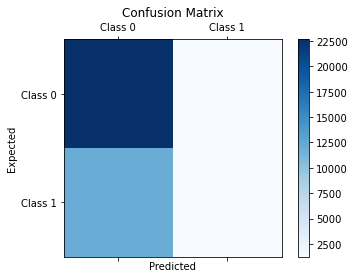

Coefficents:
-2.27e+01: Search Reason_Public Order
-8.56e+00: Search Reason_Crossbows
 7.81e+00: Search Reason_Warrant
 7.78e+00: Search Reason_Stolen Property
 7.51e+00: Search Reason_Drugs
 7.16e+00: Search Reason_Protection Of Life
 7.04e+00: Search Reason_Firearms
 7.02e+00: Search Reason_Fireworks
 6.95e+00: Search Reason_Weapons
 6.91e+00: Search Reason_Sport Event
 6.84e+00: Search Reason_Other
 6.75e+00: Search Reason_Wildlife
 6.10e+00: Search Reason_Care & Welfare
-3.37e+00: Division Desc_Renfrewshire and Inverclyde
-3.37e+00: Division Desc_Argyll and West Dunbartonshire
-3.30e+00: Division Desc_North East
-3.30e+00: Division Desc_Lanarkshire
-3.14e+00: Division Desc_Dumfries and Galloway
-3.09e+00: Division Desc_Edinburgh
-3.07e+00: Division Desc_13
-2.91e+00: Division Desc_Greater Glasgow
-2.89e+00: Division Desc_The Lothians and Scottish Borders
-2.89e+00: Division Desc_Highland and Islands
-2.85e+00: Division Desc_Forth Valley
-2.77e+00: Division Desc_Tayside
-2.50e+00: D

In [432]:
model="division"
cols = []

cols += classification_tools.list_onehot_columns(X_train_init, "Nominal Ethnicity")
cols += classification_tools.list_onehot_columns(X_train_init, "Search Reason")
cols += classification_tools.list_onehot_columns(X_train_init, "Division Desc")
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

models[model] = LogisticRegression(
    penalty="none",
    max_iter=500
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

fig, auc = classification_tools.calc_roc(models[model], X_val, y_val, title="Training ROC Curve")
fig.show()
print("Train AUC ROC score: {:.3f}".format(auc))
fig, auc = classification_tools.calc_roc(models[model], X_val, y_val, title="Validation ROC Curve")
fig.show()
print("Validate AUC ROC score: {:.3f}".format(auc))

y_train_pred = classification_tools.predict_with_threshold(models[model], X_train, threshold=0.5)
conf_mat = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = conf_mat.ravel()

print("True Negatives: {:,}\nFalse Positives: {:,}\nFalse Negatives: {:,}\nTrue Positives: {:,}\n".format(tn,fp,fn,tp))

print("True positive rate: {:3f}".format(tp/(tp+fn)))
print("False positive rate: {:3f}".format(fp/(tn+fp)))

classification_tools.plot_confusion_matrix(conf_mat)

print("Coefficents:")
coefficients = classification_tools.get_feature_weights(cols, models[model])